In [7]:
# Imports
import os
import sys
import tensorflow as tf

from InceptionModel.inception_utils import load_model, load_labels_vocabulary, make_predictions_and_gradients, top_label_id_and_score
from IntegratedGradients.integrated_gradients import integrated_gradients, random_baseline_integrated_gradients
from VisualizationLibrary.visualization_lib import Visualize, show_pil_image, pil_image

In [2]:
MODEL_LOC='./InceptionModel/tensorflow_inception_graph.pb'
LABELS_LOC='./InceptionModel/imagenet_comp_graph_label_strings.txt'

# Load the Inception model.
sess, graph = load_model(MODEL_LOC)

# Load the Labels vocabulary.
labels = load_labels_vocabulary(LABELS_LOC)

# Make the predictions_and_gradients function
inception_predictions_and_gradients = make_predictions_and_gradients(sess, graph)

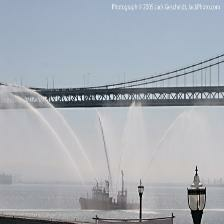

In [23]:
# Load the image.
def load_image(img_path):
  with open(img_path) as f:
    img = f.read()
    img = sess.run(tf.image.decode_jpeg(img))
    return img

img = load_image('./Images/70bfca4555cca92e.jpg')
show_pil_image(pil_image(img))

Top label: fireboat, score: 0.999985
Gradients


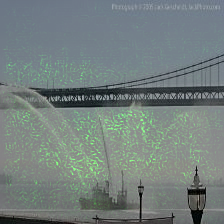

Integrated Gradients


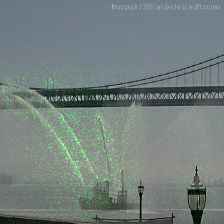

In [14]:
# Determine top label and score.
top_label_id, score = top_label_id_and_score(img, inception_predictions_and_gradients)
print "Top label: %s, score: %f" % (labels[top_label_id], score)

# Compute attributions based on just the gradients.
_, gradients = inception_predictions_and_gradients([img], top_label_id)

print 'Gradients'
show_pil_image(pil_image(Visualize(
    gradients[0], img,
    clip_above_percentile=99,
    clip_below_percentile=0,
    overlay=True)))

# Compute attributions based on the integrated gradients method.
attributions = random_baseline_integrated_gradients(
    img,
    top_label_id,
    inception_predictions_and_gradients,
    steps=50,
    num_random_trials=10)

print 'Integrated Gradients'
show_pil_image(pil_image(Visualize(
    attributions, img,
    clip_above_percentile=99,
    clip_below_percentile=0,
    overlay=True)))

Clipping
The two graphs below show the top and bottom clipping on the attribution distribution curve.


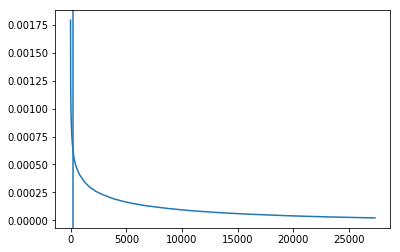

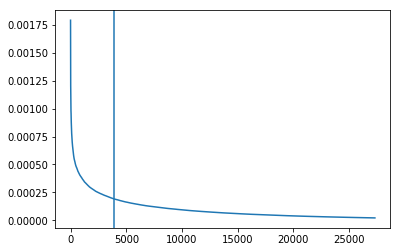

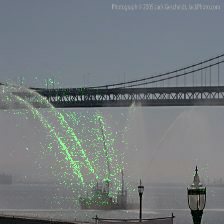

In [20]:
# Clipping
print 'Clipping'
print 'The two graphs below show the top and bottom clipping on the attribution distribution curve.'

show_pil_image(pil_image(Visualize(
    attributions, img,
    clip_above_percentile=95,
    clip_below_percentile=58,
    overlay=True,
    plot_distribution=True)))

Clipping + Morphological cleanup


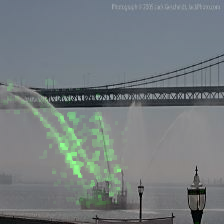

In [21]:
# Morphological cleanup
print 'Clipping + Morphological cleanup'

show_pil_image(pil_image(Visualize(
    attributions, img,
    clip_above_percentile=95,
    clip_below_percentile=58,
    morphological_cleanup=True,
    overlay=True)))

Outlines


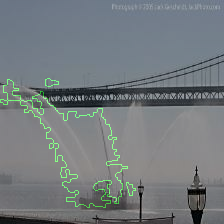

In [22]:
# Outlines
print 'Outlines'

show_pil_image(pil_image(Visualize(
    attributions, img,
    clip_above_percentile=95,
    clip_below_percentile=58,
    morphological_cleanup=True,
    outlines=True,
    overlay=True)))

Top label: baboon, score: 0.989468


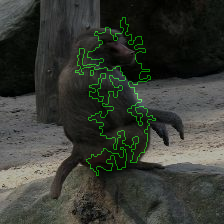

Top label: cabbage butterfly, score: 0.993752


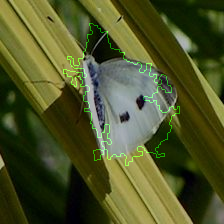

Top label: African hunting dog, score: 0.993349


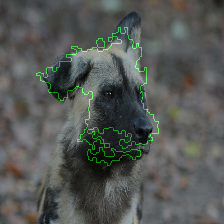

Top label: stopwatch, score: 0.998707


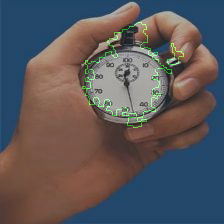

Top label: indigo bunting, score: 0.995035


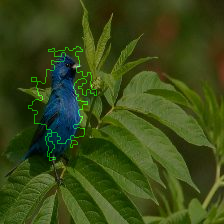

Top label: Saint Bernard, score: 0.993977


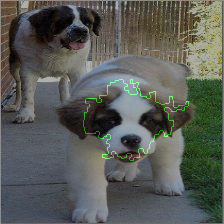

Top label: drilling platform, score: 0.999990


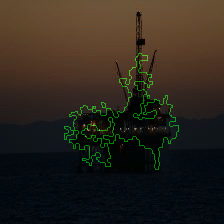

Top label: fireboat, score: 0.999985


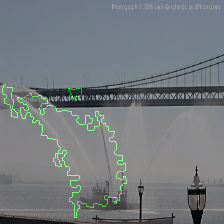

Top label: brambling, score: 0.999757


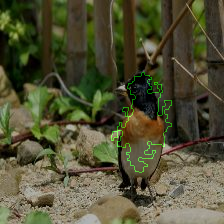

Top label: jacamar, score: 0.999746


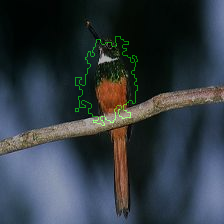

Top label: reflex camera, score: 0.999117


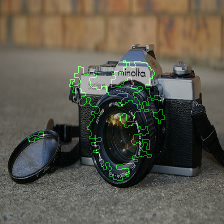

Top label: ringneck snake, score: 0.922521


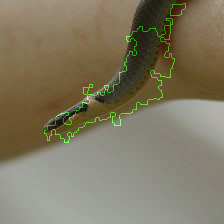

In [24]:
# Show outlines for a few example images.
image_paths = [
    "./Images/023d8b91c64faf4b.jpg",
    "./Images/1bd6987fa9219dec.jpg",
    "./Images/1e626579f6ad7b2b.jpg",
    "./Images/1eb9afc2b4e01ecd.jpg",
    "./Images/407378360d17f0e6.jpg",
    "./Images/518a1c0660c5e32e.jpg",
    "./Images/6717aba6a10b230f.jpg",
    "./Images/70bfca4555cca92e.jpg",
    "./Images/73db3c274688a2e0.jpg",
    "./Images/87fa4cf351b87562.jpg",
    "./Images/8e570672510267d3.jpg",
    "./Images/b19f875f181025d3.jpg",
]

for image_path in image_paths:
  # Load image.
  img = load_image(image_path)
    
  # Compute the top label and score.
  top_label_id, score = top_label_id_and_score(img, inception_predictions_and_gradients)
  print "Top label: %s, score: %f" % (labels[top_label_id], score)
    
  # Compute the random baseline integrated gradients.
  attributions = random_baseline_integrated_gradients(
      img,
      top_label_id,
      inception_predictions_and_gradients,
      steps=50,
      num_random_trials=10)
    
  show_pil_image(pil_image(Visualize(
      attributions, img,
      clip_above_percentile=95,
      clip_below_percentile=58,
      morphological_cleanup=True,
      outlines=True,
      overlay=True)))